In [155]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime, timedelta

# **STEP 1: DATA COLLECTION**

In [156]:
btc_data = yf.download('BTC-USD', start='2010-01-01', end='2024-10-20', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [157]:
# Header
print("______________________Overview of the Dataset_______________________")
print("\n")

# Print out the crawled data information
print(btc_data.head(4000),"\n")
print(btc_data.info())

______________________Overview of the Dataset_______________________


                    Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-10-15  66050.367188  67881.679688  64809.195312  67041.109375   
2024-10-16  67042.460938  68375.289062  66758.726562  67612.718750   
2024-10-17  67617.078125  67912.210938  66647.390625  67399.835938   
2024-10-18  67419.109375  68969.750000  67177.820312  68418.789062   
2024-10-19  68418.976562  68668.007812  68024.640625  68362.734375   

               Adj

# **STEP 2: Prepare the incidicators**

**2.1: Add indicators to the data**

**Functions to create the indicators**

In [158]:
# Function to add indicators (e.g., moving averages, RSI)
def add_indicators(df):
    # Moving Averages (MA)
    df['MA_10'] = df['Close'].rolling(window=10).mean()  # 10-day Moving Average
    df['MA_50'] = df['Close'].rolling(window=50).mean()  # 50-day Moving Average
    df['MA_200'] = df['Close'].rolling(window=200).mean()  # 200-day Moving Average
    df['MA_20'] = df['Close'].rolling(window=20).mean()  # 20-day Moving Average (needed for Bollinger Bands)
    
    # Relative Strength Index (RSI)
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands (Upper and Lower Bands) - Uses MA_20
    df['BB_upper'] = df['MA_20'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_lower'] = df['MA_20'] - 2 * df['Close'].rolling(window=20).std()
    
    # Exponential Moving Average (EMA)
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # 50-day Exponential Moving Average
    0
    return df

Việc xử lý các giá trị NaN trong dữ liệu là một bước quan trọng trong quy trình tiền xử lý dữ liệu. Câu hỏi về việc drop (loại bỏ) các hàng với giá trị NaN hay điền các giá trị thay thế (imputation) phụ thuộc vào loại dữ liệu, bài toán cụ thể, và cách bạn muốn mô hình học từ dữ liệu.

Lý do nên drop (loại bỏ) các hàng với giá trị NaN:
Dữ liệu thiếu có thể không đáng tin cậy: Nếu giá trị thiếu chiếm một phần nhỏ và không ảnh hưởng đến mẫu dữ liệu tổng thể, việc loại bỏ có thể tránh được việc tạo ra thông tin giả mạo hoặc làm méo mó dữ liệu thật.

Chỉ báo kỹ thuật cần các giá trị liền kề: Trong trường hợp các chỉ báo như Trung bình động (MA), RSI, hay Bollinger Bands, việc điền giá trị có thể không hợp lý vì các chỉ báo này phụ thuộc vào các giá trị thực tế liền kề. Ví dụ, điền vào một giá trị NaN trong Trung bình động có thể làm sai lệch thông tin về xu hướng.

Dữ liệu thiếu không nhiều: Nếu chỉ có một số hàng chứa NaN và số lượng này không đáng kể so với toàn bộ dữ liệu, việc loại bỏ các hàng đó sẽ không ảnh hưởng lớn đến kết quả dự đoán, nhưng lại giúp tránh sự phức tạp không cần thiết trong việc điền giá trị.

Lý do nên impute (điền vào giá trị thay thế) các giá trị NaN:
Bảo toàn kích thước dữ liệu: Nếu dữ liệu chứa nhiều hàng với NaN, việc loại bỏ các hàng này có thể làm giảm kích thước bộ dữ liệu đáng kể, dẫn đến mô hình kém hiệu quả hơn hoặc không có đủ thông tin để học.

Tránh mất thông tin: Loại bỏ các hàng có thể dẫn đến việc bỏ sót những thông tin quan trọng. Nếu các giá trị NaN xảy ra rải rác, việc điền giá trị vào có thể là lựa chọn hợp lý hơn.

Phương pháp điền giá trị thông minh: Bạn có thể sử dụng các phương pháp điền giá trị tiên tiến hơn, như:

Mean/Median/Mode imputation: Điền giá trị trung bình, trung vị hoặc mode của cột.
Forward fill hoặc Backward fill: Điền giá trị NaN bằng các giá trị trước hoặc sau nó.
KNN imputation: Sử dụng KNN để dự đoán giá trị thiếu dựa trên các điểm dữ liệu lân cận.
Iterative Imputer: Điền vào giá trị thiếu bằng cách dùng các cột khác để dự đoán giá trị của nó.
Ví dụ, nếu giá trị NaN xuất hiện trong cột 'Close', bạn có thể điền giá trị bằng giá trị trung bình của các ngày liền trước và liền sau.

In [159]:
# Add indicators to the dataset
btc_data = add_indicators(btc_data)

# Display the updated data with added indicators
print("\n______________________Dataset with Added Indicators_______________________")
print("\n")
print(btc_data.tail(10))  # Show the last 10 rows to check if indicators are added

# Drop rows with NaN values (due to moving averages and RSI calculations)
btc_data.dropna(inplace=True)

print("\n")
print(btc_data.info())


______________________Dataset with Added Indicators_______________________


                    Open          High           Low         Close  \
Date                                                                 
2024-10-10  60581.929688  61236.722656  58895.207031  60274.500000   
2024-10-11  60275.460938  63400.871094  60046.125000  62445.089844   
2024-10-12  62444.617188  63448.785156  62443.269531  63193.023438   
2024-10-13  63192.945312  63272.652344  62035.636719  62851.375000   
2024-10-14  62848.398438  66482.492188  62442.152344  66046.125000   
2024-10-15  66050.367188  67881.679688  64809.195312  67041.109375   
2024-10-16  67042.460938  68375.289062  66758.726562  67612.718750   
2024-10-17  67617.078125  67912.210938  66647.390625  67399.835938   
2024-10-18  67419.109375  68969.750000  67177.820312  68418.789062   
2024-10-19  68418.976562  68668.007812  68024.640625  68362.734375   

               Adj Close       Volume         MA_10         MA_50  \
Date        

# **STEP 3: Plotting to gain some insight of the data**

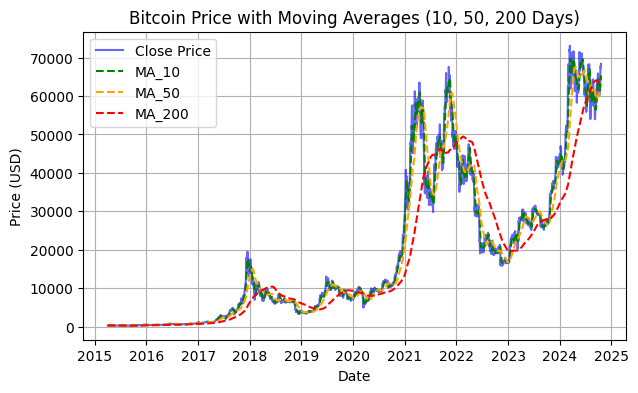

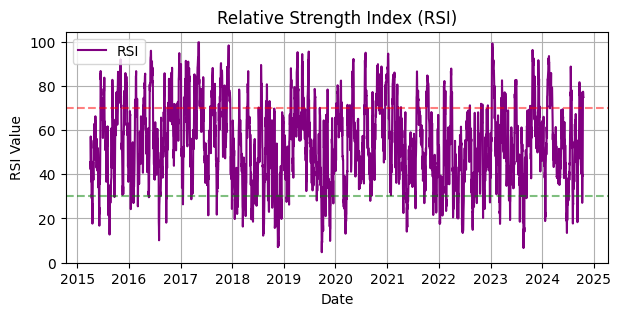

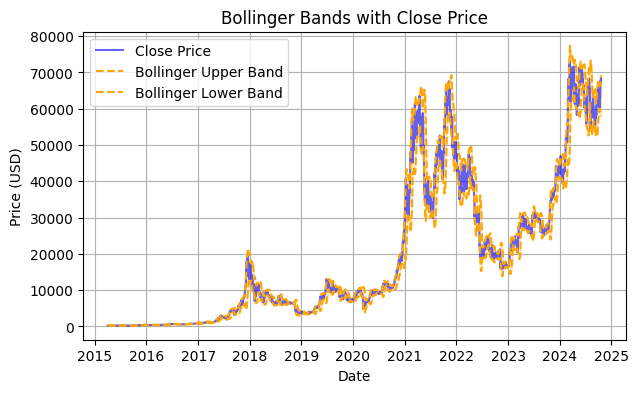

In [160]:
# Plotting price data along with Moving Averages
plt.figure(figsize=(7,4))
plt.plot(btc_data.index, btc_data['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(btc_data.index, btc_data['MA_10'], label='MA_10', color='green', linestyle='--')
plt.plot(btc_data.index, btc_data['MA_50'], label='MA_50', color='orange', linestyle='--')
plt.plot(btc_data.index, btc_data['MA_200'], label='MA_200', color='red', linestyle='--')
plt.title('Bitcoin Price with Moving Averages (10, 50, 200 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting RSI (Relative Strength Index)
plt.figure(figsize=(7,3))
plt.plot(btc_data.index, btc_data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')  # Overbought level
plt.axhline(30, linestyle='--', alpha=0.5, color='green')  # Oversold level
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Bollinger Bands along with the Closing Price
plt.figure(figsize=(7,4))
plt.plot(btc_data.index, btc_data['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(btc_data.index, btc_data['BB_upper'], label='Bollinger Upper Band', color='orange', linestyle='--')
plt.plot(btc_data.index, btc_data['BB_lower'], label='Bollinger Lower Band', color='orange', linestyle='--')
plt.fill_between(btc_data.index, btc_data['BB_lower'], btc_data['BB_upper'], color='orange', alpha=0.2)
plt.title('Bollinger Bands with Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


# **STEP 4: Data Preparation**

**4.1. Drop unrelated columns using MI**

4.1.1. Prepare the data for MI analysis

In [161]:
features = btc_data.drop(['Close'], axis=1)  # Drop the 'Close' column (target)
target = btc_data['Close']  # Target variable

4.1.2. Use mutual_info_regression to calculate MI between features and target

In [162]:
# Use mutual_info_regression to calculate MI between features and target
mi = mutual_info_regression(features, target, discrete_features=False)

4.1.3. Create a DataFrame to display feature importance using MI

In [163]:
mi_df = pd.DataFrame({'Feature': features.columns, 'MI_Score': mi})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

In [164]:
# Display the MI scores
print("\n______________________Mutual Information Scores_______________________")
print(mi_df)


______________________Mutual Information Scores_______________________
      Feature  MI_Score
3   Adj Close  6.900440
1        High  4.294667
2         Low  4.195843
0        Open  3.621920
12     EMA_10  3.325924
5       MA_10  3.161345
10   BB_upper  3.038399
8       MA_20  2.936939
13     EMA_50  2.892116
7      MA_200  2.878084
6       MA_50  2.846134
11   BB_lower  2.838011
4      Volume  1.240425
9         RSI  0.190370


4.1.3. Keep features with non-zero MI score

In [165]:
# Keep features with non-zero MI score
important_features = mi_df[mi_df['MI_Score'] > 0.05]['Feature'].tolist()

In [166]:
print(important_features)

['Adj Close', 'High', 'Low', 'Open', 'EMA_10', 'MA_10', 'BB_upper', 'MA_20', 'EMA_50', 'MA_200', 'MA_50', 'BB_lower', 'Volume', 'RSI']


4.1.4. Drop unimportant features

In [167]:
btc_data_clean = btc_data[['Close'] + important_features]

In [168]:
print("\n______________________Data After Dropping Unrelated Columns_______________________")
print(btc_data_clean.info())


______________________Data After Dropping Unrelated Columns_______________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3487 entries, 2015-04-04 to 2024-10-19
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      3487 non-null   float64
 1   Adj Close  3487 non-null   float64
 2   High       3487 non-null   float64
 3   Low        3487 non-null   float64
 4   Open       3487 non-null   float64
 5   EMA_10     3487 non-null   float64
 6   MA_10      3487 non-null   float64
 7   BB_upper   3487 non-null   float64
 8   MA_20      3487 non-null   float64
 9   EMA_50     3487 non-null   float64
 10  MA_200     3487 non-null   float64
 11  MA_50      3487 non-null   float64
 12  BB_lower   3487 non-null   float64
 13  Volume     3487 non-null   int64  
 14  RSI        3487 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 435.9 KB
None


**4.2. Shift label for future predictions**

In [169]:
k = -1
btc_data['Close'] = btc_data['Close'].shift(k)

# Drop the rows with NaN values that were created by the shift
btc_data = btc_data.dropna()

# Assesment after the drop:
print("\n_____________________Data Asessment After Shifting_______________________\n")
print(btc_data.info())


_____________________Data Asessment After Shifting_______________________

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3486 entries, 2015-04-04 to 2024-10-18
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3486 non-null   float64
 1   High       3486 non-null   float64
 2   Low        3486 non-null   float64
 3   Close      3486 non-null   float64
 4   Adj Close  3486 non-null   float64
 5   Volume     3486 non-null   int64  
 6   MA_10      3486 non-null   float64
 7   MA_50      3486 non-null   float64
 8   MA_200     3486 non-null   float64
 9   MA_20      3486 non-null   float64
 10  RSI        3486 non-null   float64
 11  BB_upper   3486 non-null   float64
 12  BB_lower   3486 non-null   float64
 13  EMA_10     3486 non-null   float64
 14  EMA_50     3486 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 435.8 KB
None


**4.3. Split training the dataset**

In [170]:
# Split the data into training and test sets
train_set, test_set = train_test_split(btc_data, test_size=0.2, random_state=42)  

# Print out some information of the split of the training set and the test set
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(2))


____________ Split training and test set ____________
2788 training + 698 test examples
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-08-12  6283.649902  6409.850098  6237.500000  6297.569824  6322.689941   
2020-04-27  7679.418945  7795.601074  7679.418945  7807.058594  7795.601074   

                 Volume        MA_10        MA_50       MA_200        MA_20  \
Date                                                                          
2018-08-12   5665250000  6691.779980  6936.913184  8165.978354  7360.181982   
2020-04-27  36162144725  7335.260889  6685.492676  7993.051758  7161.351440   

                  RSI     BB_upper     BB_lower       EMA_10       EMA_50  
Date                                                                       
2018-08-12  15.753745  8899.733156  5820.630809  6680.261204  7099.845221  
2020-04-27  72.082075  7805.883327  6516.819554  

**4.4 Separate labels from data, since we do not process label values (already processed)**

In [171]:
# Separate labels from data
X_train = train_set.drop(columns=['Close'])
y_train = train_set['Close']
X_test = test_set.drop(columns=['Close'])
y_test = test_set['Close']

**4.5. Define transfomer and fit the data**

Class for transformer

In [172]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    # Constructor takes a list of column names to select
    def __init__(self, feature_names):
        self.feature_names = feature_names  # Store the list of column names

    # The fit method doesn't need to do anything, it just returns self
    # to be compatible with scikit-learn's pipeline process
    def fit(self, dataframe, labels=None):
        return self

    # The transform method selects columns from the DataFrame based on the list of column names
    # and returns the values as a NumPy array
    def transform(self, dataframe):
        return dataframe[self.feature_names].values  # Select and return columns as a NumPy array


In [173]:
# Define numerical features
numerical_features = ['Open', 'High', 'Low', 'Volume', 'Adj Close', 'MA_10', 'MA_50', 'MA_200', 'RSI', 'MA_20', 'BB_upper', 
                      'BB_lower', 'EMA_10', 'EMA_50']

# Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(numerical_features)),  # Select numeric columns
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),  # Fill missing values with median
    ('std_scaler', StandardScaler(with_mean=True, with_std=True))  # Normalize to zero mean and unit variance
])

**4.6. Run the pipeline to process training data:**

In [174]:
processed_train_set_val = num_pipeline.fit_transform(train_set)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
X_train = pd.DataFrame(X_train, columns=numerical_features)
X_test = pd.DataFrame(X_test, columns=numerical_features)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :]) # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')   #  Save the pipeline 



____________ Processed feature values ____________
[[-0.64786916 -0.64866896 -0.64226741 -0.67984596 -0.64580658 -0.6264198
  -0.60814285 -0.51888655 -2.06621151 -0.5911603  -0.5621572  -0.62227485
  -0.62756885 -0.60277627]
 [-0.57774545 -0.5806206  -0.56820436  0.89832113 -0.57203025 -0.59393885
  -0.62107278 -0.52854449  0.97759582 -0.60124813 -0.61227535 -0.58301305
  -0.59081736 -0.59646061]
 [-0.93271612 -0.93327836 -0.93133595 -0.97098276 -0.93190361 -0.93358348
  -0.93426033 -0.94402605 -0.15454761 -0.93382291 -0.94172982 -0.91684962
  -0.93420614 -0.93856507]]
(2788, 14)


['models/num_pipeline.pkl']

# **STEP 5: TRAIN AND EVALUATE MODELS**

In [175]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

In [176]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

**5.1. Try LightGBM**

In [177]:
model = lgb.LGBMRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ LGBMRegressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 2788, number of used features: 14
[LightGBM] [Info] Start training from score 19230.210608

____________ LGBMRegressor ____________

R2 score (on training data, best=1): 0.9993814718892408
Root Mean Square Error:  496.57005973741786

Predictions:  [  279.92503098 49576.17528261]
Labels:       [237.5489959716797, 47093.8515625]
Model successfully saved as LGBMRegressor_model.pkl


**5.2. Try XGBoost model.**

In [178]:
model = XGBRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ XGBoost_Regressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________ XGBoost_Regressor ____________

R2 score (on training data, best=1): 0.999924320797362
Root Mean Square Error:  173.69570645351718

Predictions:  [  237.48027 49717.883  ]
Labels:       [237.5489959716797, 47093.8515625]
Model successfully saved as XGBRegressor_model.pkl


**5.3. Try Decision Tree.**

**NOTE:** Cây quyết định dễ bị overfitting: Nếu bạn không điều chỉnh độ sâu tối đa của cây (max_depth), mô hình có thể quá khớp với dữ liệu huấn luyện, dẫn đến điểm R² gần 1 và RMSE rất thấp trên tập huấn luyện. Tuy nhiên, khi dự đoán trên dữ liệu kiểm tra, mô hình sẽ không hoạt động tốt.

max_depth xác định độ sâu tối đa của cây quyết định. Điều này có nghĩa là cây sẽ không phát triển thêm các nhánh mới sau khi đạt đến chiều cao tối đa này.

Việc lựa chọn giá trị tối ưu cho max_depth thường được thực hiện thông qua các phương pháp tìm kiếm như Grid Search hoặc Random Search, kết hợp với k-fold cross-validation để tìm ra cấu hình tốt nhất cho mô hình.

Ngăn chặn Overfitting: Đặt giá trị max_depth thấp hơn có thể giúp ngăn ngừa việc cây quyết định quá khớp với dữ liệu huấn luyện, từ đó cải thiện khả năng tổng quát của mô hình trên dữ liệu kiểm tra.

Giảm Hiệu suất: Nếu max_depth quá thấp, mô hình có thể không đủ phức tạp để nắm bắt các mối quan hệ trong dữ liệu, dẫn đến hiệu suất kém (underfitting).

In [179]:
model = DecisionTreeRegressor(max_depth = 10) # ĐÃ SỬA
model.fit(X_train, y_train)

print('\n____________DecisionTreeRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________DecisionTreeRegressor____________

R2 score (on training data, best=1): 0.9996728073291935
Root Mean Square Error:  361.16245204669417

Predictions:  [  239.64111592 48706.00948661]
Labels:       [237.5489959716797, 47093.8515625]
Model successfully saved as DecisionTreeRegressor_model.pkl


**5.4. Try Polynomial Regression (in-lecture).**

In [180]:
# Sử dụng PolynomialFeatures kết hợp với một mô hình hồi quy
degree = 3
model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('lin_reg', LinearRegression())
])

model.fit(X_train, y_train)

print('\n____________PolynomialRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________PolynomialRegressor____________

R2 score (on training data, best=1): 0.9992431085558148
Root Mean Square Error:  549.3101293540749

Predictions:  [  228.10372101 45434.20025043]
Labels:       [237.5489959716797, 47093.8515625]
Model successfully saved as Pipeline_model.pkl


**5.5. Try Linear Regressor (in-lecture).**

In [181]:
model = LinearRegression() #fix here
model.fit(X_train, y_train)

print('\n____________LinearRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________LinearRegressor____________

R2 score (on training data, best=1): 0.9978439830435855
Root Mean Square Error:  927.1006713814411

Predictions:  [  276.09310675 49491.19243656]
Labels:       [237.5489959716797, 47093.8515625]
Model successfully saved as LinearRegression_model.pkl


**5.6. Try Random Forest (in-lecture).**

In [182]:
model = RandomForestRegressor(n_estimators = 100) # ĐÃ SỬA
model.fit(X_train, y_train)

print('\n____________RandomForestRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________RandomForestRegressor____________

R2 score (on training data, best=1): 0.9996474684578734
Root Mean Square Error:  374.8864987433667

Predictions:  [  237.56385986 49447.19511719]
Labels:       [237.5489959716797, 47093.8515625]
Model successfully saved as RandomForestRegressor_model.pkl


**5.7. Try K-Nearest-Neighbor**

In [183]:
model = KNeighborsRegressor(n_neighbors=5)  # ADJUST
model.fit(X_train, y_train)

print('\n____________KNeighborsRegressor____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

# Lưu mô hình đã huấn luyện
store_model(model)


____________KNeighborsRegressor____________

R2 score (on training data, best=1): 0.9976853330880466
Root Mean Square Error:  960.6054831203362

Predictions:  [  279.11440125 51418.71796875]
Labels:       [237.5489959716797, 47093.8515625]
Model successfully saved as KNeighborsRegressor_model.pkl


## **LƯU Ý PHẢI ĐIỀU CHÌNH CÁC HỆ SỐ ĐỂ ĐƯA RA KẾT QUẢ TỐT NHẤT**

# **STEP 6: K-CROSS VALIDATION**

In [184]:
cv = KFold(n_splits=5, shuffle=True, random_state=37)

In [185]:
def evaluate_and_plot(model, model_name, X_train, y_train, cv):
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    residuals = y_train - y_train_pred

    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    joblib.dump(residuals, 'saved_objects/' + model_name + '_residuals.pkl')  # Lưu residuals
    
    print(f"{model_name} RMSE: ", rmse_scores)
    print(f"Avg. RMSE: ", np.mean(rmse_scores), '\n')
    
    plt.figure(figsize=(7, 7))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Residual Distribution for {model_name} Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [186]:
def load_and_print_rmse_with_plot(model_name):
    # Load RMSE scores
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    
    # Load residuals
    residuals = joblib.load('saved_objects/' + model_name + '_residuals.pkl')
    
    # Print RMSE and average RMSE
    print(f"{model_name} RMSE: ", rmse_scores)
    print(f"Avg. RMSE: ", np.mean(rmse_scores), '\n')
    
    # Plot residual distribution
    plt.figure(figsize=(5, 5))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Residual Distribution for {model_name} Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


LinearRegression RMSE:  [870.55287529 891.88761822 844.26397907 920.94319291 990.92321904]
Avg. RMSE:  903.7141769067824 



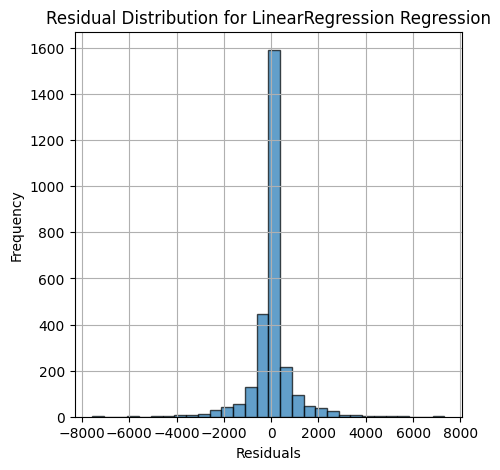

In [187]:
model_name = "LinearRegression"
run_new_evaluation = 0  # Set to 0 if you want to load the saved results

if run_new_evaluation == 1:
    model = LinearRegression()
    evaluate_and_plot(model, model_name, X_train, y_train, cv)
else:
    load_and_print_rmse_with_plot(model_name)

PolynomialRegression RMSE:  [5094.70266962 4289.70986921 4253.28309083 1755.83887872 6305.6834663 ]
Avg. RMSE:  4339.8435949344885 



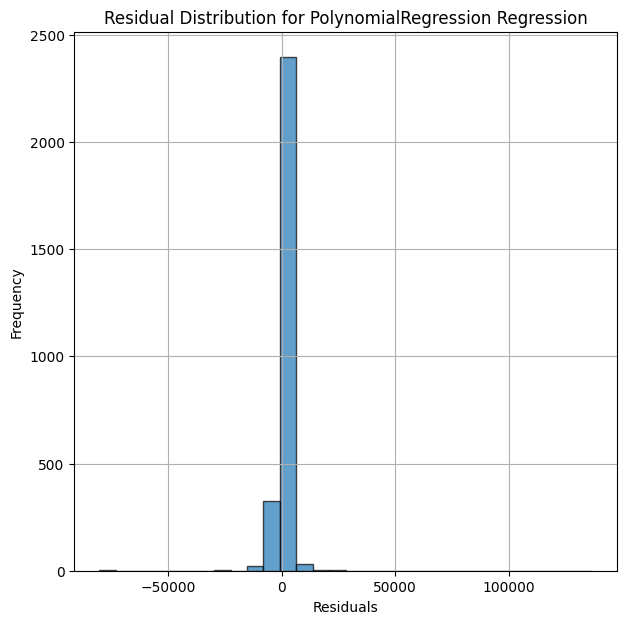

In [188]:
model_name = "PolynomialRegression"
run_new_evaluation = 1  # Set to 0 if you want to load the saved results

if run_new_evaluation == 1:
    model = Pipeline([('poly_features', PolynomialFeatures(degree=3)), ('lin_reg', LinearRegression())])
    evaluate_and_plot(model, model_name, X_train, y_train, cv)
else:
    load_and_print_rmse_with_plot(model_name)


DecisionTreeRegressor RMSE:  [1267.01048819 1332.46751745 1233.08003064 1288.07525599 1210.59086542]
Avg. RMSE:  1266.2448315378965 



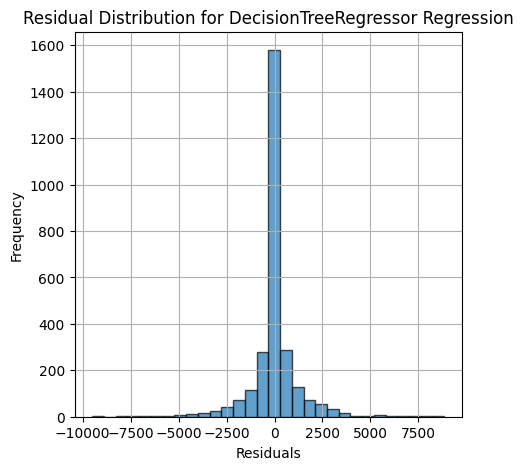

In [189]:
model_name = "DecisionTreeRegressor"
run_new_evaluation = 0  # Set to 0 if you want to load the saved results

if run_new_evaluation == 1:
    model = DecisionTreeRegressor(max_depth=10)
    evaluate_and_plot(model, model_name, X_train, y_train, cv)
else:
    load_and_print_rmse_with_plot(model_name)


LightGBM RMSE:  [1004.59156575  994.2652513   962.67660744 1056.39320154 1116.8437828 ]
Avg. RMSE:  1026.9540817666887 



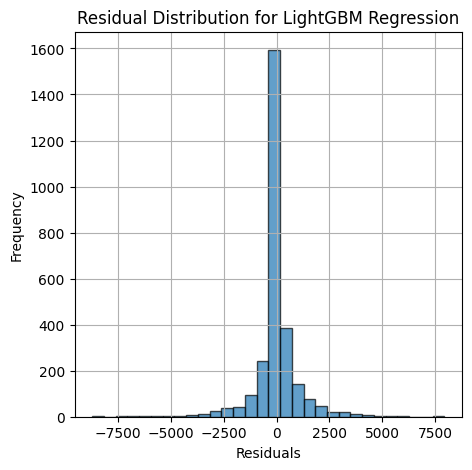

In [190]:
model_name = "LightGBM"
run_new_evaluation = 0  # Set to 0 if you want to load the saved results

if run_new_evaluation == 1:
    model = lgb.LGBMRegressor()
    evaluate_and_plot(model, model_name, X_train, y_train, cv)
else:
    load_and_print_rmse_with_plot(model_name)


XGBoostRegressor RMSE:  [1066.12211203 1174.20028414 1010.75920434  978.92954296 1118.07393231]
Avg. RMSE:  1069.6170151576976 



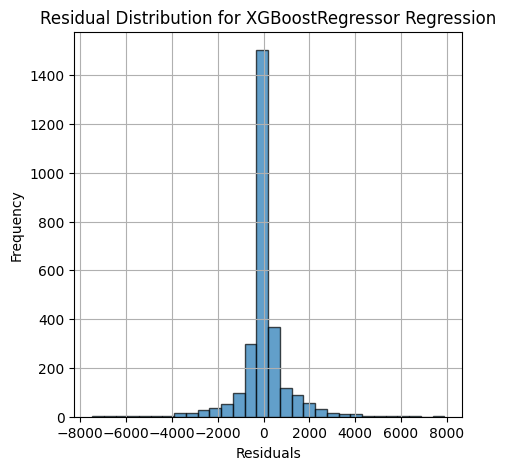

In [191]:
model_name = "XGBoostRegressor"
run_new_evaluation = 0  # Set to 0 if you want to load the saved results

if run_new_evaluation == 1:
    model = XGBRegressor()
    evaluate_and_plot(model, model_name, X_train, y_train, cv)
else:
    load_and_print_rmse_with_plot(model_name)


RandomForestRegressor RMSE:  [ 964.67632203  982.61100226  939.56359716 1014.71101951 1062.63956486]
Avg. RMSE:  992.8403011630487 



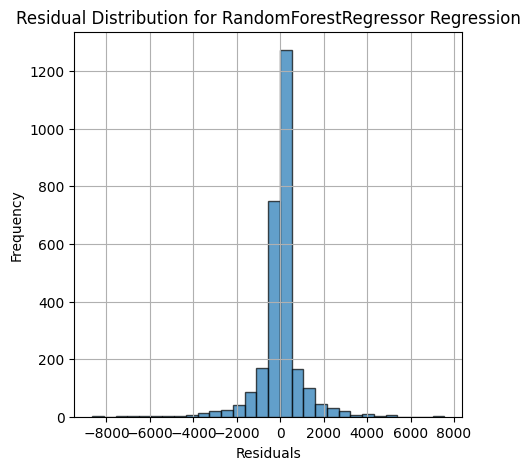

In [192]:
model_name = "RandomForestRegressor"
run_new_evaluation = 0  # Set to 0 if you want to load the saved results

if run_new_evaluation == 1:
    model = RandomForestRegressor(n_estimators=100)
    evaluate_and_plot(model, model_name, X_train, y_train, cv)
else:
    load_and_print_rmse_with_plot(model_name)


KNeighbour RMSE:  [1277.4508593  1271.22271231 1109.96267614 1181.25560871 1262.26328285]
Avg. RMSE:  1220.4310278626106 



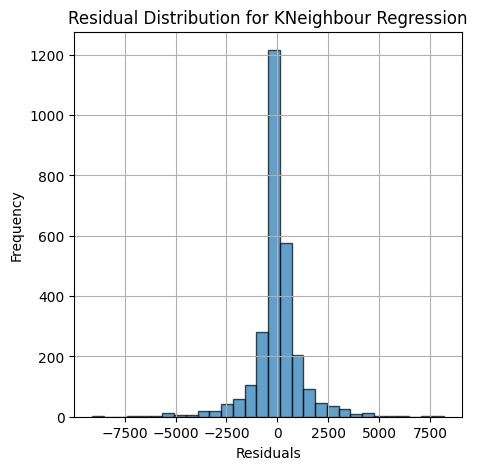

In [193]:
model_name = "KNeighbour"
run_new_evaluation = 0  # Set to 0 if you want to load the saved results

if run_new_evaluation == 1:
    model = KNeighborsRegressor(n_neighbors=5)
    evaluate_and_plot(model, model_name, X_train, y_train, cv)
else:
    load_and_print_rmse_with_plot(model_name)

In [194]:
print("--> Loại RandomForestRegressor, Loại XGBoostRegressor, Loại LightGBM, loại DecisionTree")

--> Loại RandomForestRegressor, Loại XGBoostRegressor, Loại LightGBM, loại DecisionTree


# **STEP 7: FINE-TUNING**

In [195]:
# Function to print results of grid search
def print_search_result(grid_search, model_name=""):
    print("\n====== Fine-tune " + model_name +" ======")
    print('Best hyperparameter combination: ',grid_search.best_params_)
    print('Best rmse: ', np.sqrt(-grid_search.best_score_)) 
    print('Performance of hyperparameter combinations:')
    cv_results = grid_search.cv_results_
    for (mean_score, params) in zip(cv_results["mean_test_score"], cv_results["params"]):
        print('rmse =', np.sqrt(-mean_score), params)

In [196]:
cv = KFold(n_splits=5, shuffle=True, random_state=37)

**7.1. Fine-tuning PolynomialRegressor:**

In [197]:
run_new_search = 0

if run_new_search == 1:
    # Create the polynomial features pipeline
    poly_model = Pipeline([
        ('poly_features', PolynomialFeatures()),
        ('scaler', StandardScaler()),
        ('lin_reg', LinearRegression())
    ])
    
    # Define the parameter grid
    param_grid = {
        'poly_features__degree': [2, 3, 4],
        'lin_reg__fit_intercept': [True, False],
    }
    
    # Set-up cross validation
    cv = 5
    
    # Set up and run grid search
    grid_search = GridSearchCV(estimator=poly_model, param_grid=param_grid, 
                               scoring='neg_mean_squared_error', cv=cv, 
                               n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Save grid search results
    joblib.dump(grid_search, 'saved_objects/PolynomialRegression_gridsearch.pkl')

    # Print search results
    print_search_result(grid_search, "PolynomialRegression")

else:
    # Load previously saved grid search results
    grid_search = joblib.load('saved_objects/PolynomialRegression_gridsearch.pkl')
    print_search_result(grid_search, model_name="PolynomialRegression")




====== Fine-tune PolynomialRegression ======
Best hyperparameter combination:  {'lin_reg__fit_intercept': True, 'poly_features__degree': 2}
Best rmse:  976.0406060454417
Performance of hyperparameter combinations:
rmse = 976.0406060454417 {'lin_reg__fit_intercept': True, 'poly_features__degree': 2}
rmse = 4703.099036640625 {'lin_reg__fit_intercept': True, 'poly_features__degree': 3}
rmse = 552216433.314847 {'lin_reg__fit_intercept': True, 'poly_features__degree': 4}
rmse = 64774.4692516645 {'lin_reg__fit_intercept': False, 'poly_features__degree': 2}
rmse = 80800.95222157071 {'lin_reg__fit_intercept': False, 'poly_features__degree': 3}
rmse = 2523615217482.8955 {'lin_reg__fit_intercept': False, 'poly_features__degree': 4}


In [198]:
run_new_search = 0
if run_new_search:
    # Define a parameter grid for KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to use
        'weights': ['uniform', 'distance'],  # Weight function used in prediction
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
        'leaf_size': [10, 30, 50],  # Leaf size passed to BallTree or KDTree
        'p': [1, 2]  # Power parameter for the Minkowski metric
    }
    
    # Set up and run grid search
    knn_model = KNeighborsRegressor()
    grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Save grid search results
    joblib.dump(grid_search, 'saved_objects/KNNRegressor_gridsearch.pkl')

    # Print search results
    print_search_result(grid_search, "KNNRegressor")

    # Get best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)

else:
    # Load previously saved grid search results
    grid_search = joblib.load('saved_objects/KNNRegressor_gridsearch.pkl')
    print_search_result(grid_search, model_name="KNNRegressor")
    
    # Get best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)


====== Fine-tune KNNRegressor ======
Best hyperparameter combination:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best rmse:  1037.9205358376505
Performance of hyperparameter combinations:
rmse = 1071.6462474686737 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
rmse = 1050.2041959730238 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
rmse = 1254.6872589356608 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
rmse = 1210.1996254013989 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
rmse = 1070.4942001996978 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
rmse = 1037.9205358376505 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
rmse = 1227.0932184628136 {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, '

# **STEP 8: ANALYZE AND TEST YOUR SOLUTION:**

**8.1. Pick the best model - the solution**

In [199]:
search = joblib.load('saved_objects/PolynomialRegression_gridsearch.pkl')
best_model = search.best_estimator_
print('\n____________ ANALYZE AND TEST SOLUTION ____________')
print('SOLUTION: ' , best_model)
store_model(best_model, model_name="SOLUTION")   


____________ ANALYZE AND TEST SOLUTION ____________
SOLUTION:  Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
Model successfully saved as SOLUTION_model.pkl


**8.2. Run on test-data and predicts**

In [200]:
try:
    num_pipeline = joblib.load(r'models/num_pipeline.pkl')
except FileNotFoundError:
    print("Error: num_pipeline.pkl file not found. Make sure you have saved the pipeline.")
    # Nếu không tìm thấy file, bạn có thể cần phải tạo và lưu pipeline trước

processed_test_set = num_pipeline.transform(test_set)
# 7.3.1 Compute R2 score and root mean squared error
r2score, rmse = r2score_and_rmse(best_model, processed_test_set, y_test)
print('\nPerformance on test data:')
print('R2 score (on test data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 7.3.2 Predict labels for some test instances
print("\nTest data: \n", X_test.iloc[0:9])
print("\nPredictions: ", best_model.predict(processed_test_set[0:9]).round(decimals=1))
print("Labels:      ", list(y_test[0:9]),'\n')
print("\nProcessed: \n", processed_test_set)


Performance on test data:
R2 score (on test data, best=1): 0.9983498539406596
Root Mean Square Error:  834.664786143499

Test data: 
        Open      High       Low    Volume  Adj Close     MA_10     MA_50  \
0 -0.951672 -0.951755 -0.950549 -0.971992  -0.950678 -0.952406 -0.952807   
1  1.489923  1.555212  1.462433  2.323131   1.527177  1.676947  1.122236   
2  1.405442  1.400825  1.446604 -0.124407   1.430303  1.267482  1.254831   
3 -0.951596 -0.951625 -0.950477 -0.971806  -0.950462 -0.952231 -0.952934   
4 -0.493785 -0.495387 -0.509184 -0.694280  -0.518415 -0.434409 -0.445357   
5 -0.952010 -0.952005 -0.950879 -0.972325  -0.950862 -0.952711 -0.952897   
6  0.013459 -0.005307 -0.002285  0.779830  -0.025854 -0.032087 -0.163681   
7 -0.828373 -0.816117 -0.824439 -0.864880  -0.819088 -0.841305 -0.871660   
8  1.848040  1.889176  1.835907  1.964867   1.932886  1.647523  1.320911   

     MA_200       RSI     MA_20  BB_upper  BB_lower    EMA_10    EMA_50  
0 -0.961158  0.404607 -0.95276

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


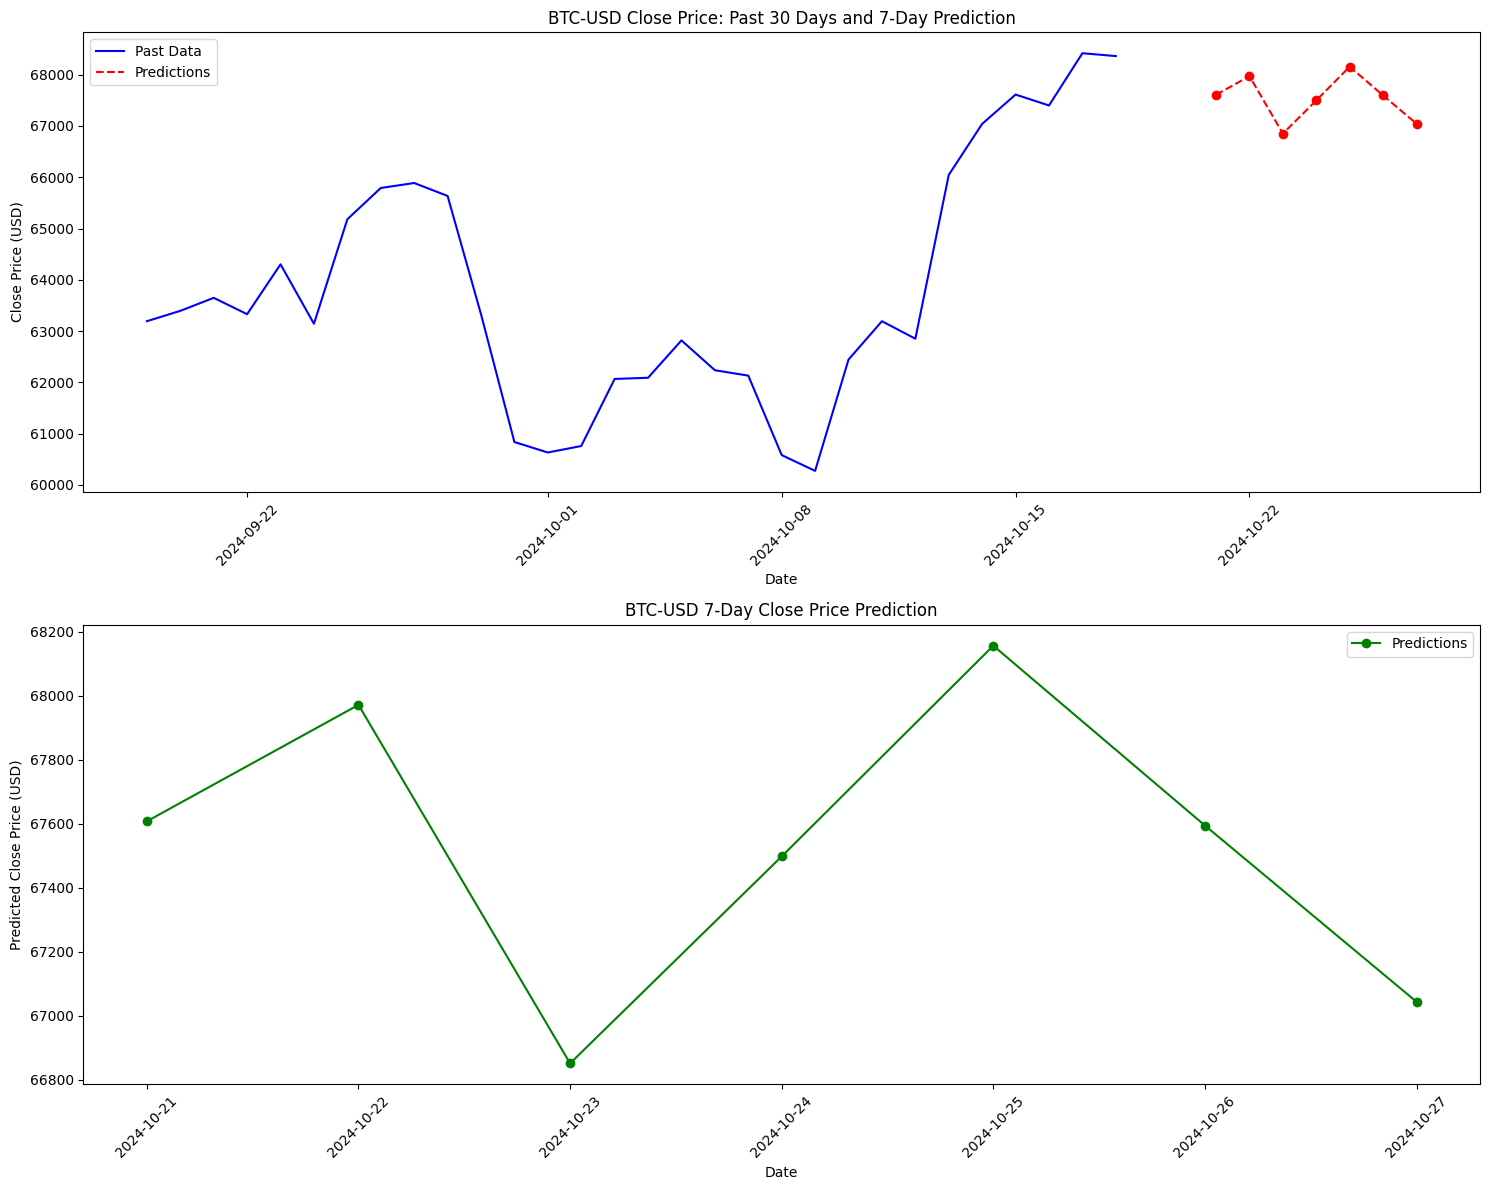


Predictions Close Price for the next 7 days:
2024-10-21: $67608.05
2024-10-22: $67971.69
2024-10-23: $66851.75
2024-10-24: $67498.25
2024-10-25: $68156.53
2024-10-26: $67594.87
2024-10-27: $67044.16


In [201]:

# Load the best model and pipeline
best_model = joblib.load('models/SOLUTION_model.pkl')
num_pipeline = joblib.load('models/num_pipeline.pkl')

# Get today's date
today = datetime.now().date()

# Create a date range for the next 7 days
future_dates = [today + timedelta(days=i) for i in range(7)]

# Function to create features for a single day with some randomness
def create_features(prev_data, date):
    features = prev_data.copy()
    features['Date'] = date
    features['DayOfWeek'] = date.weekday()
    features['DayOfMonth'] = date.day
    features['Month'] = date.month
    
    # Add some randomness to the price
    random_change = np.random.normal(0, 0.02)  # 2% standard deviation
    features['Close'] *= (1 + random_change)
    features['Open'] *= (1 + random_change)
    features['High'] *= (1 + random_change * 1.1)  # Slightly higher for High
    features['Low'] *= (1 + random_change * 0.9)   # Slightly lower for Low
    
    # Add randomness to volume
    features['Volume'] *= (1 + np.random.normal(0, 0.1))  # 10% standard deviation
    
    return features

# Create future data
future_data = []
prev_day_data = btc_data.iloc[-1].to_dict()
for date in future_dates:
    day_data = create_features(prev_day_data, date)
    future_data.append(day_data)
    prev_day_data = day_data  # Use this day's data as the basis for the next day

# Convert to DataFrame
future_df = pd.DataFrame(future_data)

# Ensure future_df has the same columns as the training data
for col in btc_data.columns:
    if col not in future_df.columns:
        future_df[col] = np.nan

# Align columns with the original dataset
future_df = future_df[btc_data.columns]

# Combine historical data with future dates
combined_df = pd.concat([btc_data, future_df], axis=0)

# Process the entire dataset
processed_data = num_pipeline.transform(combined_df)

# Make predictions for the entire dataset
all_predictions = best_model.predict(processed_data)

# Extract predictions for the future dates
future_predictions = all_predictions[-7:]

# Get the last 30 days of actual data for context
last_30_days = btc_data.iloc[-30:]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Past data and future predictions
ax1.plot(last_30_days.index, last_30_days['Close'], label='Past Data', color='blue')
ax1.plot(future_dates, future_predictions, label='Predictions', color='red', linestyle='--')
ax1.scatter(future_dates, future_predictions, color='red')
ax1.set_title('BTC-USD Close Price: Past 30 Days and 7-Day Prediction')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Only future predictions
ax2.plot(future_dates, future_predictions, label='Predictions', color='green', marker='o')
ax2.set_title('BTC-USD 7-Day Close Price Prediction')
ax2.set_xlabel('Date')
ax2.set_ylabel('Predicted Close Price (USD)')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print out the predictions
print("\nPredictions Close Price for the next 7 days:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


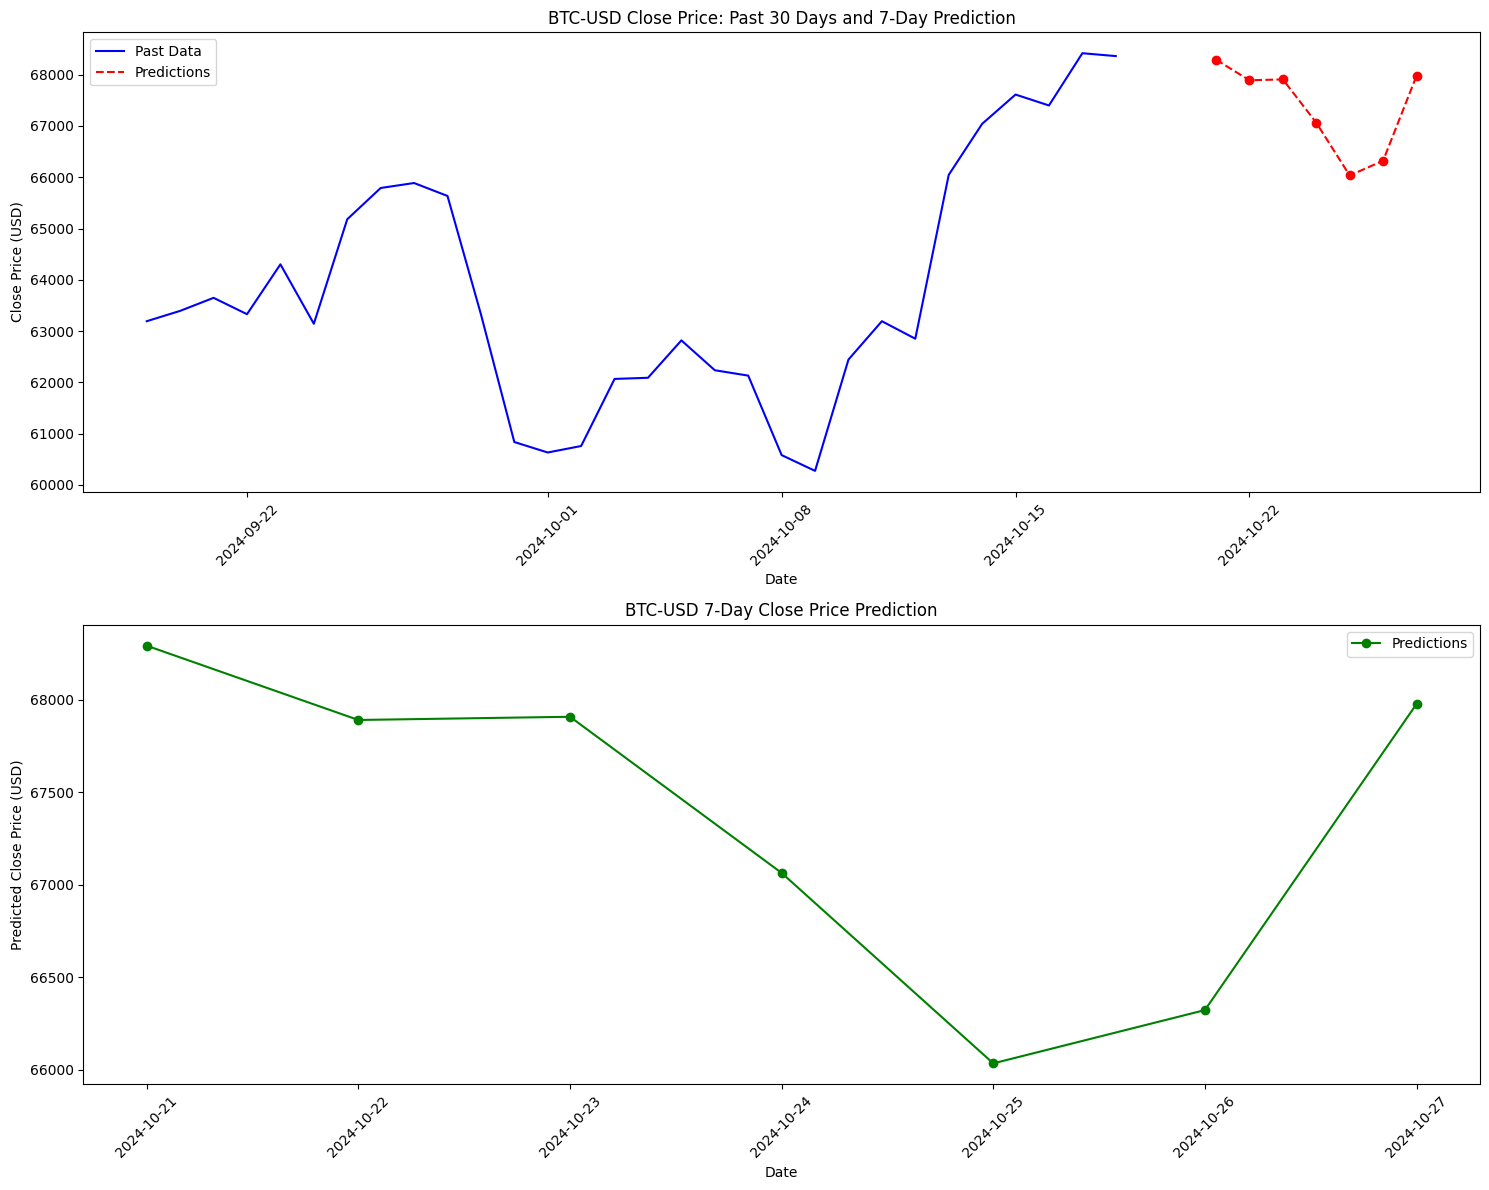


Predictions Close Price for the next 7 days:
2024-10-21: $68292.53
2024-10-22: $67891.03
2024-10-23: $67908.41
2024-10-24: $67064.00
2024-10-25: $66034.56
2024-10-26: $66322.64
2024-10-27: $67977.23


In [206]:
# Create future data
future_data = []
prev_day_data = btc_data.iloc[-1].to_dict()  # Dùng ngày cuối cùng trong dữ liệu quá khứ
for date in future_dates:
    day_data = create_features(prev_day_data, date)
    future_data.append(day_data)
    prev_day_data = day_data  # Sử dụng dữ liệu của ngày hiện tại cho ngày tiếp theo

# Convert to DataFrame
future_df = pd.DataFrame(future_data)

# Ensure future_df has the same columns as the training data
for col in btc_data.columns:
    if col not in future_df.columns:
        future_df[col] = np.nan

# Align columns with the original dataset
future_df = future_df[btc_data.columns]

# Combine historical data with future dates
combined_df = pd.concat([btc_data, future_df], axis=0)

# Tạo lại các trục x cho biểu đồ
# Vẽ dự đoán nối tiếp ngay sau dữ liệu quá khứ

# Process the entire dataset
processed_data = num_pipeline.transform(combined_df)

# Make predictions for the entire dataset
all_predictions = best_model.predict(processed_data)

# Extract predictions for the future dates
future_predictions = all_predictions[-7:]

# Get the last 30 days of actual data for context
last_30_days = btc_data.iloc[-30:]
dates_for_past_and_future = list(last_30_days.index) + future_dates  # Kết hợp ngày của dữ liệu quá khứ và dự đoán

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Past data and future predictions nối tiếp nhau
ax1.plot(last_30_days.index, last_30_days['Close'], label='Past Data', color='blue')
ax1.plot(future_dates, future_predictions, label='Predictions', color='red', linestyle='--')
ax1.scatter(future_dates, future_predictions, color='red')
ax1.set_title('BTC-USD Close Price: Past 30 Days and 7-Day Prediction')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Only future predictions
ax2.plot(future_dates, future_predictions, label='Predictions', color='green', marker='o')
ax2.set_title('BTC-USD 7-Day Close Price Prediction')
ax2.set_xlabel('Date')
ax2.set_ylabel('Predicted Close Price (USD)')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print out the predictions
print("\nPredictions Close Price for the next 7 days:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")
